#8. 도로 영역을 찾자! - 세그멘테이션 모델 만들기

이번에는 Semantic Segmentation을 이용해서 자율주행차량이 주행해야 할 도로 영역을 찾는 모델을 만들어보겠습니다. 
 

모델로는 U-Net과 U-Net++를 사용하도록 하겠습니다.


또한, IOU값으로 어떤 모델이 더 높은 스코어를 나타내는지도 비교해보겠습니다.

밑에 사진과 같은 기술이 세그멘테이션 입니다.

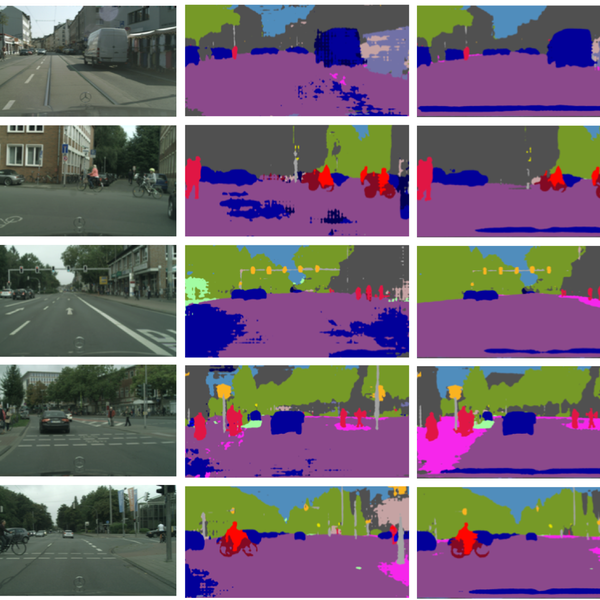

목차

- 구글 드라이브 및 라이브러리 임포트

- 데이터 전처리

- 모델 제작

- U-Net모델 제작(노드 실습 코드)

- U-Net모델 제작(자체 제작)

- U-Net모델 제작(UpSampling2D)

- 모델 결과 저장

- 학습 결과 시각화

- U-Net++모델 제작

- 모델 IOU 값 확인

- 마무리

---

##구글 드라이브 및 라이브러리 임포트

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#필요한 라이브러리를 로드합니다. 
import os
import math
import numpy as np
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob
import skimage
import albumentations

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

---

##데이터 전처리

###데이터 파일 로드

DATA_PATH라는 변수를 지정하여 사용할 이미지의 경로를 저장시켜줍니다.

In [ ]:
DATA_PATH = "/content/drive/MyDrive/data"

---


###Image Augmentation

사용할 이미지들을 Augmentation 시키는 함수 생성

Augmentation을 하는 이유는 오버피팅을 방지하고 다양한 이미지로 변형 시키고 학습하므로

결과 향상을 이끌어내줍니다.

In [ ]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
    if is_train:
        return Compose([
            HorizontalFlip(p=0.5),
            RandomSizedCrop(
                min_max_height=(300, 370),
                w2h_ratio=370/1242,
                height=224,
                width=224,
                p=0.5
            ),
            Resize(
                width=224,
                height=224
            )
        ])
    return Compose([
        Resize(
            width=224,
            height=224
        )
    ])

---

###이미지 시각화

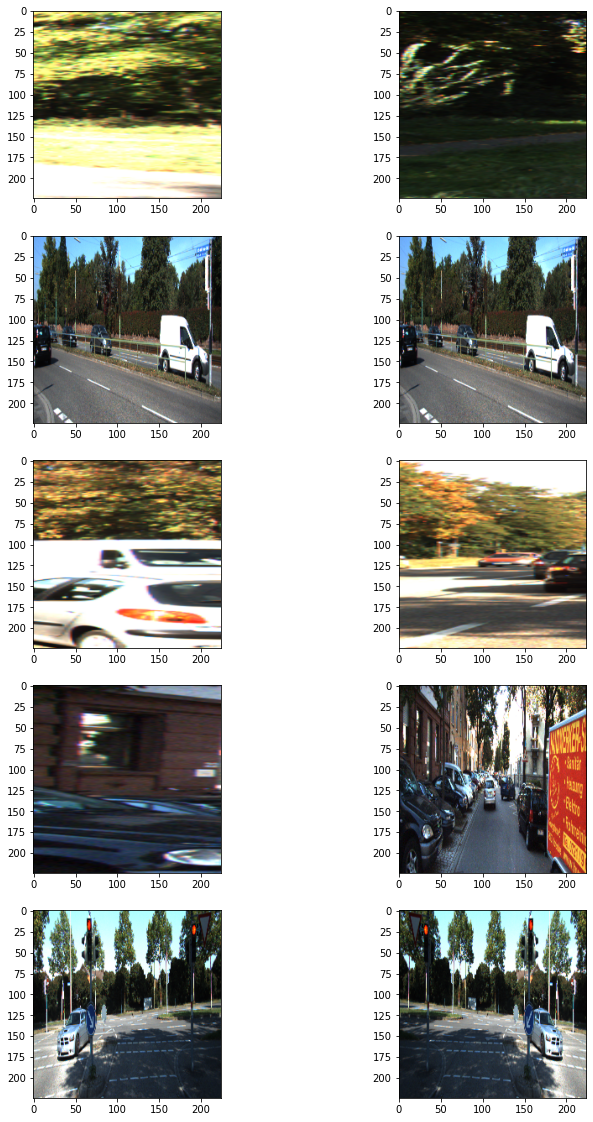

In [ ]:
dir_path = '/content/drive/MyDrive/data/training'

augmentation = build_augmentation()
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i])
    image_data = {"image": image}
    resized = augmentation(**image_data, is_train=False)
    processed = augmentation(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])

plt.show()

---

###데이터셋 구현

이번에는 tf.keras.utils.Sequence를 상속받은 generator 형태로 데이터를 구성해 보겠습니다.

In [ ]:
class KittiGenerator(tf.keras.utils.Sequence):
    def __init__(self,
                 dir_path,
                 batch_size=4,
                 img_size=(224, 224, 3),
                 output_size=(224, 224),
                 is_train=True,
                 augmentation=None):
        '''
        dir_path: dataset의 directory path입니다.
        batch_size: batch_size입니다.
        img_size: preprocess에 사용할 입력이미지의 크기입니다.
        output_size: ground_truth를 만들어주기 위한 크기입니다.
        is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
        augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
        '''
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.is_train = is_train
        self.dir_path = dir_path
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size
        # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
        self.data = self.load_dataset()

    def load_dataset(self):
        # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
        # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
        input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
        label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
        input_images.sort()
        label_images.sort()
        assert len(input_images) == len(label_images)
        data = [_ for _ in zip(input_images, label_images)]

        if self.is_train:
            return data[:-30]
        return data[-30:]

    def __len__(self):
        # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
        return math.ceil(len(self.data) / self.batch_size)

    def __getitem__(self, index):
        # 입력과 출력을 만듭니다.
        # 입력은 resize및 augmentation이 적용된 input image이고 
        # 출력은 semantic label입니다.
        batch_data = self.data[
            index*self.batch_size:
            (index + 1)*self.batch_size
        ]
        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])

        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = imread(input_img_path)
            _output = imread(output_path)
            _output = (_output == 7).astype(np.uint8)*1
            data = {
                "image": _input,
                "mask": _output,
            }
            augmented = self.augmentation(**data)
            inputs[i] = augmented["image"]/255
            outputs[i] = augmented["mask"]
            return inputs, outputs

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.data))
        if self.is_train == True:
            np.random.shuffle(self.indexes)
            return self.indexes

---

###데이터셋 분리

학습용 데이터와 평가용 데이터로 분리를 해줍니다.

In [ ]:
# augmentation = build_augmentation()
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)

train_generator = KittiGenerator(
    dir_path,
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path,
    augmentation=test_preproc,
    is_train=False
)

---

##모델 제작

###U-Net모델 제작(노드 실습 코드)

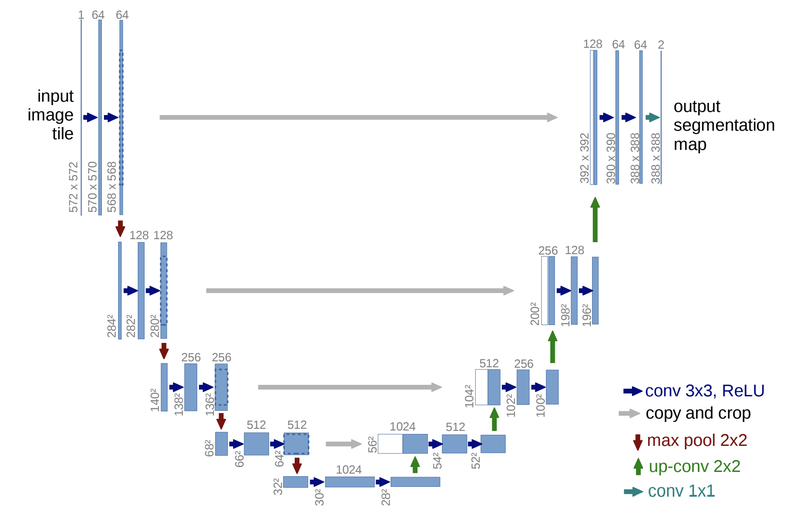

위에서 나온 모델 형식으로 기반으로 U-Net을 만들어 보겠습니다.

우선은 실습으로 구현한 코드를 그대로 사용해보겠습니다.

In [ ]:
def build_model(input_shape=(224, 224, 3)):

    inputs = Input(input_shape)

    #다운 샘플링
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
  
    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv5)
  
    #업 샘플링
    drop5 = Dropout(0.5)(conv5)
    up6 = Conv2DTranspose(512, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(drop5)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv6)
    up7 = Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv6)
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv7)
    up8 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv7)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv8)
    up9 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv8)
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)  
    conv9 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)     
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)
    return model

In [ ]:
hist1 = build_model()
hist1.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy')

In [ ]:
hist1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 224, 224, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

---

###모델 구조 시각화

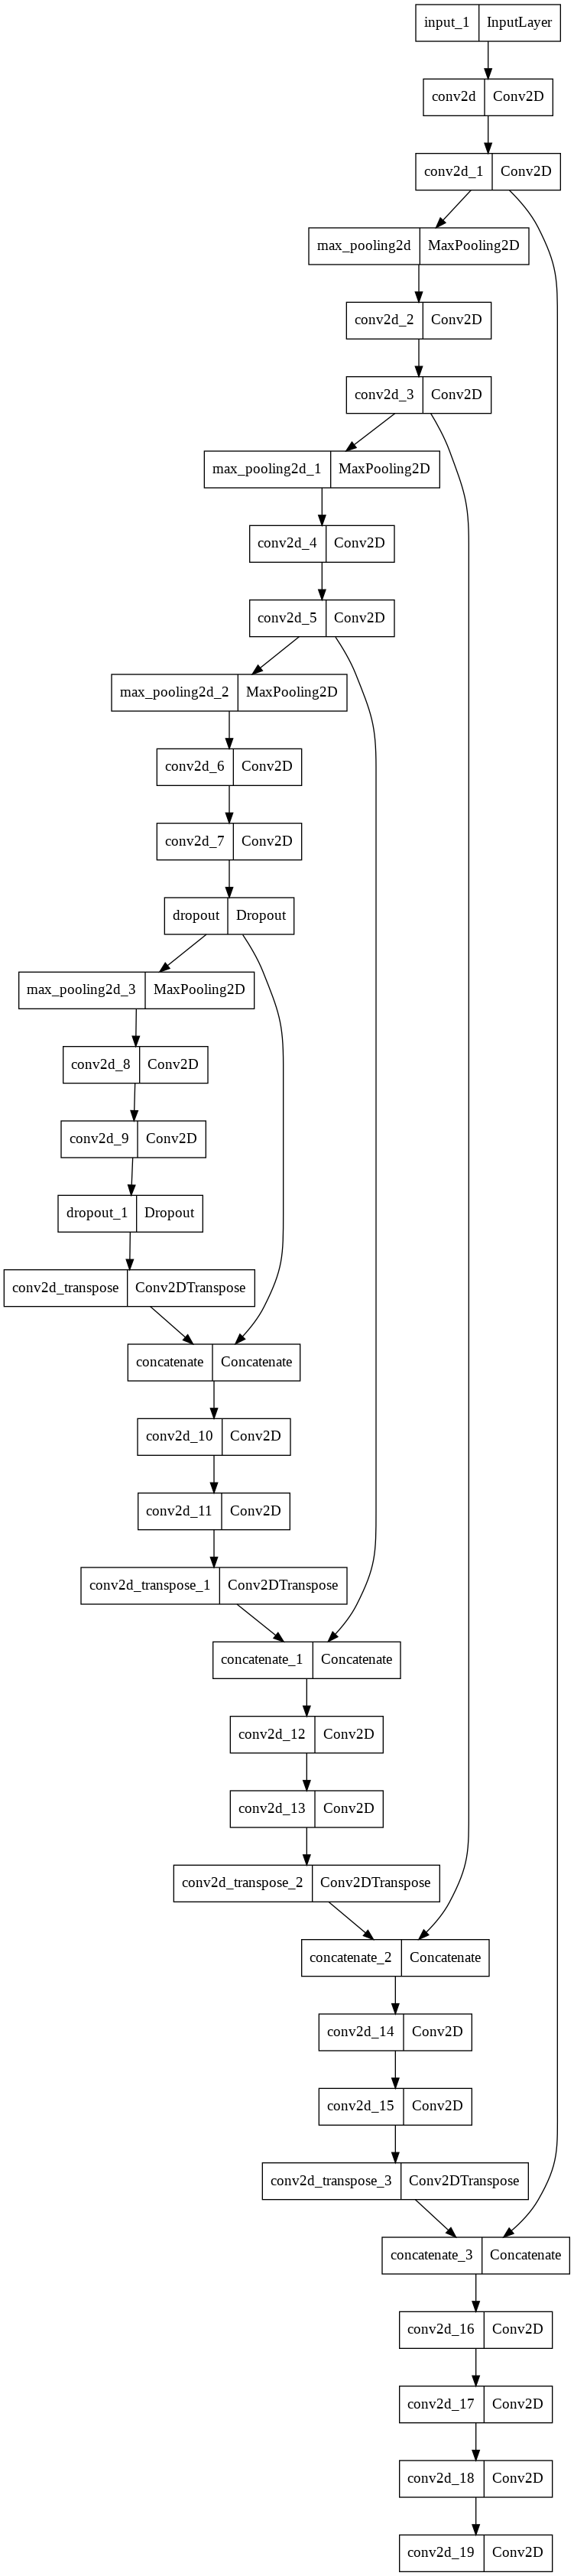

In [ ]:
tf.keras.utils.plot_model(hist1, to_file='/content/drive/MyDrive/data/U-Net.png')

---

###U-Net 모델 함수로 구현(자체 제작)

이번에는 U-Net 모델을 함수로 만들어서 좀 더 간략화 시켜보겠습니다.

In [ ]:
def conv_block(size, lay):
  conv = Conv2D(size, 3, activation='relu', padding='same',kernel_initializer='he_normal')(lay)
  conv = Conv2D(size, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv)
  batch = BatchNormalization()(conv)

  return batch

In [ ]:
def build_model2(input_shape = (224, 224, 3)):
  inputs = Input(input_shape)
  #다운 샘플링
  conv1 = conv_block(64, inputs)
  pool1 = MaxPooling2D(pool_size = (2, 2))(conv1)

  conv2 = conv_block(128, pool1)
  pool2 = MaxPooling2D(pool_size = (2, 2))(conv2)

  conv3 = conv_block(256, pool2)
  pool3 = MaxPooling2D(pool_size = (2, 2))(conv3)

  conv4 = conv_block(512, pool3)
  pool4 = MaxPooling2D(pool_size = (2, 2))(conv4)


  conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
  batch5 = BatchNormalization()(conv5)

  #업 샘플링
  up1 = Conv2DTranspose(512, 2, activation='relu', padding='same', strides=(2,2), kernel_initializer='he_normal')(batch5)
  merge1 = concatenate([conv4, up1], axis = 3)
  conv6 = conv_block(512, merge1)

  up2 = Conv2DTranspose(256, 2, activation='relu', padding='same', strides=(2,2), kernel_initializer='he_normal')(conv6)
  merge2 = concatenate([conv3, up2], axis = 3)
  conv7 = conv_block(256, merge2)

  up3 = Conv2DTranspose(128, 2, activation='relu', padding='same', strides=(2,2), kernel_initializer='he_normal')(conv7)
  merge3 = concatenate([conv2, up3], axis = 3)
  conv8 = conv_block(128, merge3)

  up4 = Conv2DTranspose(64, 2, activation='relu', padding='same',strides=(2,2), kernel_initializer='he_normal')(conv8)
  merge4 = concatenate([conv1, up4], axis = 3)

  conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge4)
  conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)  
  conv9 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)     
  conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

  model = Model(inputs = inputs, outputs = conv10)
  return model

In [ ]:
unet3 = build_model2()
unet3.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy')
unet3.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_20 (Conv2D)             (None, 224, 224, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_21 (Conv2D)             (None, 224, 224, 64  36928       ['conv2d_20[0][0]']              
                                )                                                           

---

###U-Net 모델 함수로 구현(UpSampling2D)사용

위에서는 Conv2DTranspose를 사용하여 이미지 크기를 키워주었습니다.

하지만 이번 함수에서는 UpSampling2D를 사용하여 이미지 크기를 늘려보겠습니다.

UpSampling2D 특징

- UpSampling2D는 케라스 기준 내부적으로 resize_images() 를 호출한다. 즉, 적은 해상도를 일부러 고해상도로 올리는것이다.

- 단순히 잡아 늘리는 역할으로 바로 Conv2D의 함수가 호출되어야 될 필요가 있음

Conv2DTranspose 특징

- Convolution 연산이 들어가서 해상도를 키운다. 이 연산은 당연히 학습과정에서 필터가 학습이 된다.

즉, **UpSampling은 단순히 잡아 늘리는 기능이기 때문에 따로 Conv2D 레이어를 따로 써주어야 합니다**.

저 **형식에 맞추어서 구현**해보겠습니다.

In [ ]:
def build_model1(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)
    
    conv1 = conv_block(64, inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = conv_block(128, pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = conv_block(256, pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = conv_block(512, pool3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)


    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
    batch5 = BatchNormalization()(conv5)
    

    up1 = Conv2D(512, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(batch5)) 
    merge1 = concatenate([conv4,up1])
    conv6 = conv_block(512, merge1)

    up2 = Conv2D(256, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv6))
    crop_conv3 = tf.image.resize(conv3, (up2.shape[1], up2.shape[2]))
    merge2 = concatenate([crop_conv3,up2])
    conv7 = conv_block(256, merge2)

    up3 = Conv2D(128, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv7))
    crop_conv2 = tf.image.resize(conv2, (up3.shape[1], up3.shape[2]))
    merge3 = concatenate([crop_conv2,up3])
    conv8 = conv_block(128, merge3)

    up4 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv8))
    crop_conv1 = tf.image.resize(conv1, (up4.shape[1], up4.shape[2]))
    merge4 = concatenate([crop_conv1, up4])
    conv9 = conv_block(64, merge4)
    conv9 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)     
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)
    conv10 = tf.image.resize(conv10, (input_shape[0], input_shape[1]))

    model = Model(inputs = inputs, outputs = conv10)
    return model

In [ ]:
unet4 = build_model1()
unet4.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy')
unet4.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_39 (Conv2D)             (None, 224, 224, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_40 (Conv2D)             (None, 224, 224, 64  36928       ['conv2d_39[0][0]']              
                                )                                                           

---

###모델 구조 시각화

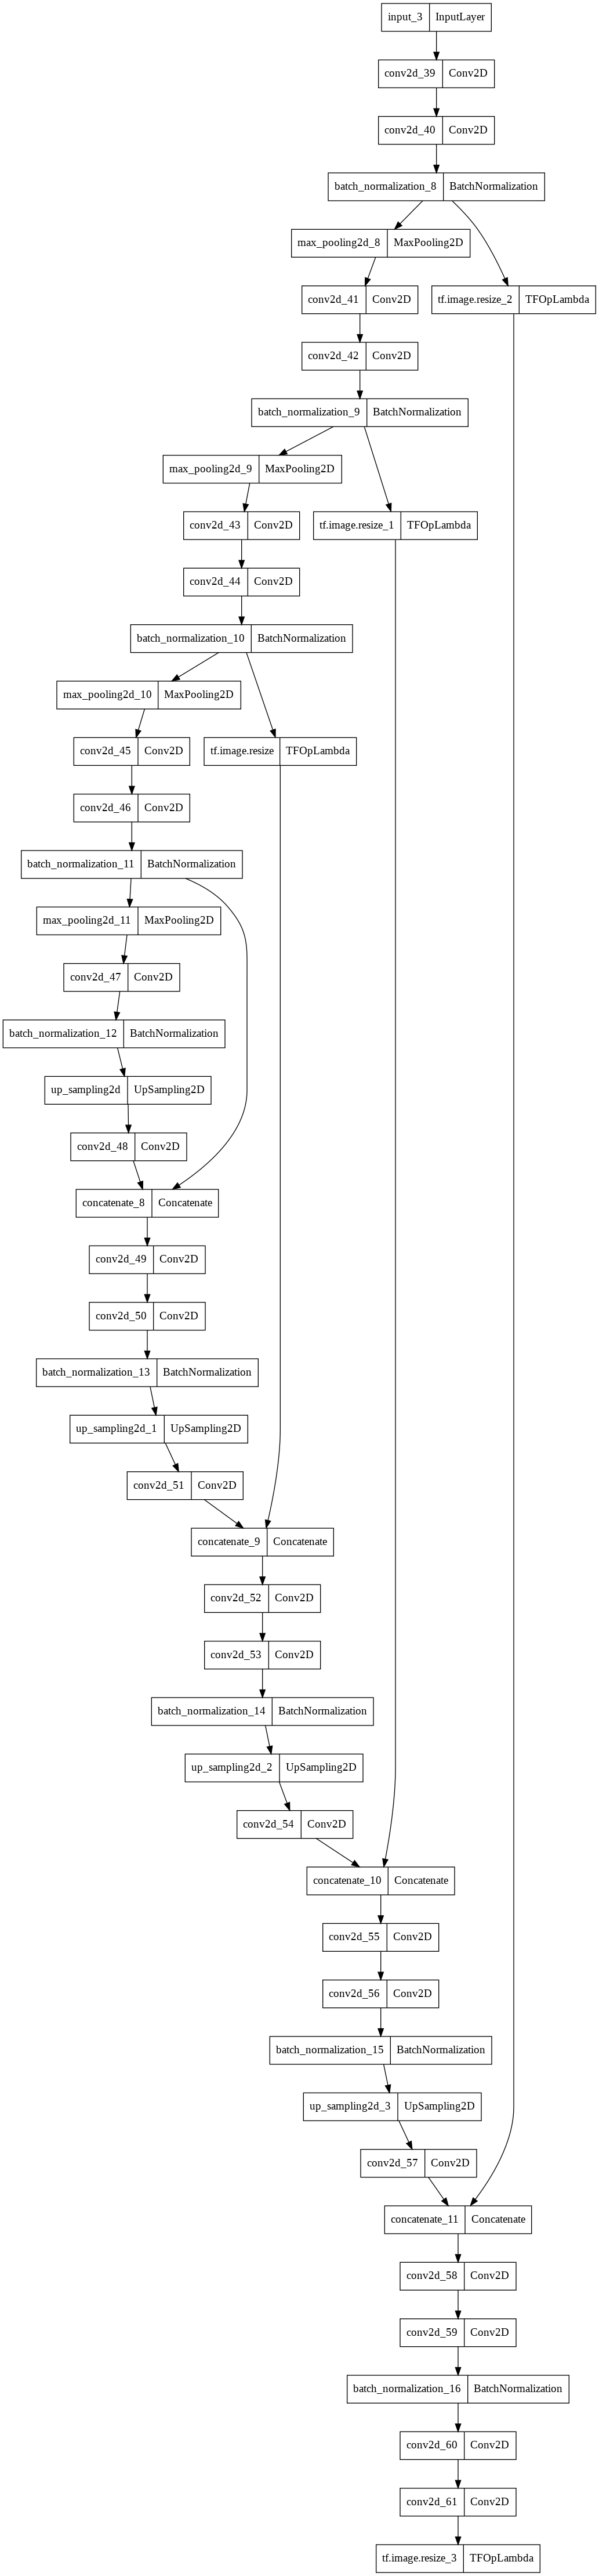

In [ ]:
tf.keras.utils.plot_model(unet4, to_file='/content/drive/MyDrive/data/U-Net.png')

---

##U-Net 모델 학습(노드 실습 코드)

노드에 있는 실습코드로 만든 모델을 가장 먼저 학습시켜 보겠습니다.

In [ ]:
ba_model = hist1.fit_generator(
    generator=train_generator,
    validation_data=test_generator,
    steps_per_epoch=len(train_generator),
    epochs=100,
)

Epoch 1/100
43/43 [==============================] - 30s 406ms/step - loss: 0.4930 - val_loss: 0.1280
Epoch 2/100
43/43 [==============================] - 5s 111ms/step - loss: 0.1341 - val_loss: 0.1114
Epoch 3/100
43/43 [==============================] - 5s 110ms/step - loss: 0.0989 - val_loss: 0.0870
Epoch 4/100
43/43 [==============================] - 5s 111ms/step - loss: 0.0782 - val_loss: 0.0855
Epoch 5/100
43/43 [==============================] - 5s 110ms/step - loss: 0.0870 - val_loss: 0.0996
Epoch 6/100
43/43 [==============================] - 5s 110ms/step - loss: 0.0833 - val_loss: 0.0842
Epoch 7/100
43/43 [==============================] - 5s 110ms/step - loss: 0.0833 - val_loss: 0.1455
Epoch 8/100
43/43 [==============================] - 5s 110ms/step - loss: 0.0885 - val_loss: 0.0819
Epoch 9/100
43/43 [==============================] - 5s 110ms/step - loss: 0.0771 - val_loss: 0.0777
Epoch 10/100
43/43 [==============================] - 5s 110ms/step - loss: 0.0720 - val_l

---

##U-Net 모델 학습(자체 제작)

이번에는 제가 직접 만든 모델을 한번 학습시켜보겠습니다.

In [ ]:
U_net1 = unet3.fit_generator(
    generator=train_generator,
    validation_data=test_generator,
    steps_per_epoch=len(train_generator),
    epochs=100,
)

Epoch 1/100
43/43 [==============================] - 7s 137ms/step - loss: 0.1592 - val_loss: 0.3048
Epoch 2/100
43/43 [==============================] - 5s 106ms/step - loss: 0.0836 - val_loss: 0.1922
Epoch 3/100
43/43 [==============================] - 5s 106ms/step - loss: 0.0610 - val_loss: 0.1464
Epoch 4/100
43/43 [==============================] - 5s 107ms/step - loss: 0.0696 - val_loss: 0.1954
Epoch 5/100
43/43 [==============================] - 5s 107ms/step - loss: 0.0600 - val_loss: 0.1348
Epoch 6/100
43/43 [==============================] - 5s 107ms/step - loss: 0.0527 - val_loss: 0.0862
Epoch 7/100
43/43 [==============================] - 5s 106ms/step - loss: 0.0659 - val_loss: 0.0808
Epoch 8/100
43/43 [==============================] - 5s 106ms/step - loss: 0.0514 - val_loss: 0.1164
Epoch 9/100
43/43 [==============================] - 5s 106ms/step - loss: 0.0480 - val_loss: 0.0939
Epoch 10/100
43/43 [==============================] - 5s 106ms/step - loss: 0.0430 - val_lo

---

##U-Net 모델 학습(UpSampling2D 사용)

In [ ]:
U_net2 = unet4.fit_generator(
    generator=train_generator,
    validation_data=test_generator,
    steps_per_epoch=len(train_generator),
    epochs=100,
)

Epoch 1/100
43/43 [==============================] - 9s 162ms/step - loss: 0.3436 - val_loss: 0.4790
Epoch 2/100
43/43 [==============================] - 6s 142ms/step - loss: 0.2153 - val_loss: 0.2701
Epoch 3/100
43/43 [==============================] - 6s 141ms/step - loss: 0.1926 - val_loss: 0.2133
Epoch 4/100
43/43 [==============================] - 6s 142ms/step - loss: 0.1883 - val_loss: 0.1997
Epoch 5/100
43/43 [==============================] - 6s 142ms/step - loss: 0.1789 - val_loss: 0.1950
Epoch 6/100
43/43 [==============================] - 6s 142ms/step - loss: 0.1733 - val_loss: 0.1878
Epoch 7/100
43/43 [==============================] - 6s 142ms/step - loss: 0.1696 - val_loss: 0.1817
Epoch 8/100
43/43 [==============================] - 6s 141ms/step - loss: 0.1659 - val_loss: 0.1754
Epoch 9/100
43/43 [==============================] - 6s 142ms/step - loss: 0.1634 - val_loss: 0.1794
Epoch 10/100
43/43 [==============================] - 6s 143ms/step - loss: 0.1640 - val_lo

---

##모델 결과 저장

위에서 학습한 모델들 결과를 따로 저장해 두겠습니다.

In [ ]:
model_path3 = '/content/drive/MyDrive/data/unet_model2.h5'
unet4.save(model_path3)
model_path4 = '/content/drive/MyDrive/data/model2.h5'
hist1.save(model_path4)

In [ ]:
model_path5 = '/content/drive/MyDrive/data/model3.h5'
unet3.save(model_path5)

---

##학습 결과 시각화

위에서 학습한 모델들의 학습결과를 시각화 해보겠습니다.

차례대로

- ba_model 노드 실습 모델

- U_net1 자체 제작 모델

- U_net2 UpSampling2D 사용

In [ ]:
def draw_unet_history(history, model_name='hist1'):
    plt.figure(figsize=(12,4))
    plt.plot(history.history['loss'], 'r')
    plt.plot(history.history['val_loss'], 'b')
    plt.title(f'{model_name} Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['loss', 'val_loss'], loc='upper left')

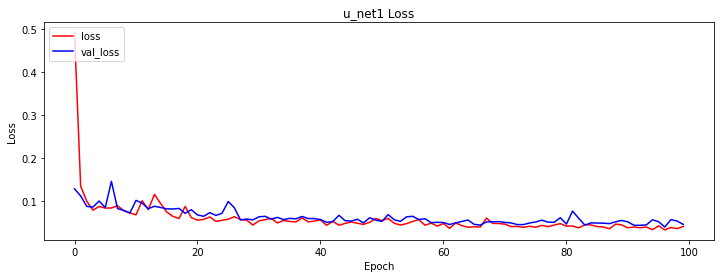

In [ ]:
draw_unet_history(ba_model, 'u_net1')

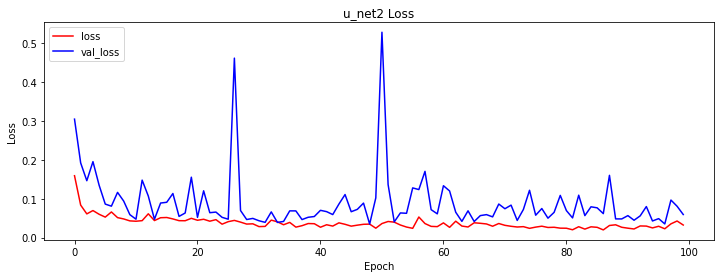

In [ ]:
draw_unet_history(U_net1, 'u_net2')

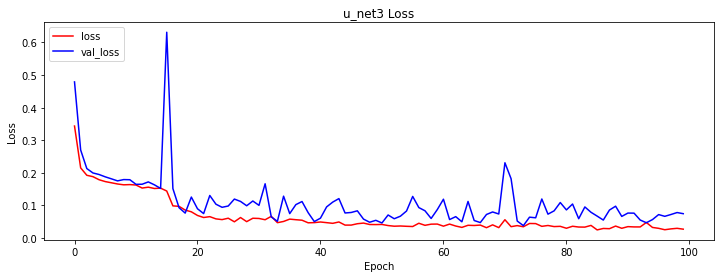

In [ ]:
draw_unet_history(U_net2, 'u_net3')

---

##U-Net++ 모델 제작

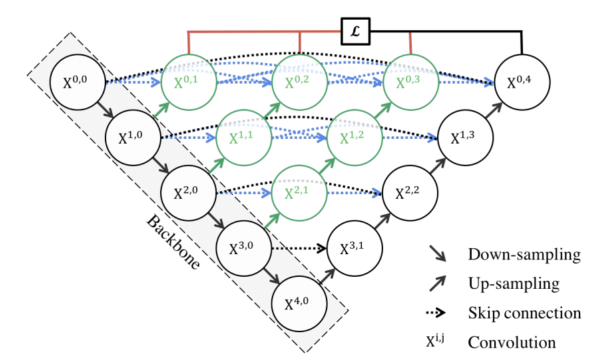

이번에는 U-Net에서 발전한 U-Net++모델을 만들어 보겠습니다.

###U-Net++ 제작(깃허브 참고)

U-Net++ 모델을 만들어 보겠습니다.

U-Net++는 U-Net의 네트워크 구조 + DenseNet 의 아이디어로 성능을 개선한 모델입니다.

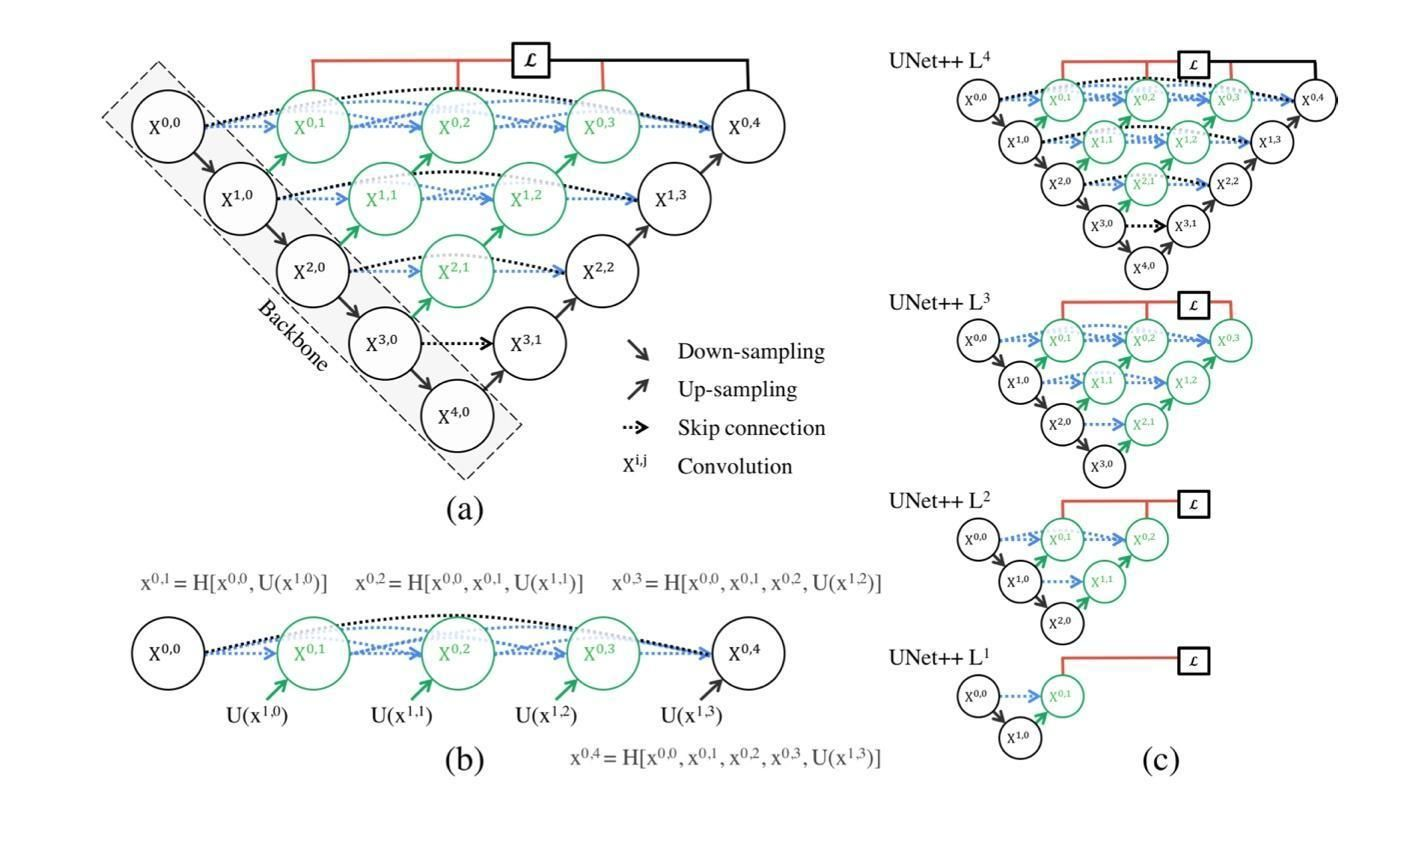

Re-designed skip pathways : DenseNet의 아이디어를 차용하여 Encoder(수축 경로)와 

Decoder(확장 경로)사이의 Semantic(의미적) Gap을 연결시켜 줌

Deep Supervision : 각 브랜치의 출력(빨간색 선으로 표시된 부분)을 평균해서 최종 결과로서 사용하는 방법

In [ ]:
def conv_batch(layer, filters):
    conv = Conv2D(filters, 3, activation='relu', padding='valid',kernel_initializer='he_normal')(layer)
    conv = Conv2D(filters, 3, activation='relu', padding='valid',kernel_initializer='he_normal')(conv)
    batch = BatchNormalization()(conv)
    
    return batch

def build_UNet_plus(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)
    
    conv1 = conv_batch(inputs, 64)
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = conv_batch(pool1, 128)
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = conv_batch(pool2, 256)
    
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = conv_batch(pool3, 512)
    
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
    batch5 = BatchNormalization()(conv5)
    
    
    up_conv2 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv2))
    skip_crop_conv1 = tf.image.resize(conv1, (up_conv2.shape[1], up_conv2.shape[2]))
    merge1_1 = concatenate([skip_crop_conv1, up_conv2])
    conv1_1 = conv_batch(merge1_1, 64)
    
    up_conv3 = Conv2D(128, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv3))
    skip_crop_conv2 = tf.image.resize(conv2, (up_conv3.shape[1], up_conv3.shape[2]))
    merge2_1 = concatenate([skip_crop_conv2 , up_conv3])
    conv2_1 = conv_batch(merge2_1, 128)
    
    up_conv4 = Conv2D(256, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv4))
    skip_crop_conv3 = tf.image.resize(conv3, (up_conv4.shape[1], up_conv4.shape[2]))
    merge3_1 = concatenate([skip_crop_conv3, up_conv4])
    conv3_1 = conv_batch(merge3_1, 256)
    
    up_conv2_1 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv2_1))
    skip_crop_conv1 = tf.image.resize(conv1, (up_conv2_1.shape[1], up_conv2_1.shape[2]))
    skip_crop_conv1_1 = tf.image.resize(conv1_1, (up_conv2_1.shape[1], up_conv2_1.shape[2]))
    merge1_2 = concatenate([skip_crop_conv1, skip_crop_conv1_1, up_conv2_1])
    conv1_2 = conv_batch(merge1_2, 64)
    
    up_conv3_1 = Conv2D(256, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv3_1))
    skip_crop_conv2 = tf.image.resize(conv2, (up_conv3_1.shape[1], up_conv3_1.shape[2]))
    skip_crop_conv2_1 = tf.image.resize(conv2_1, (up_conv3_1.shape[1], up_conv3_1.shape[2]))
    merge2_2 = concatenate([skip_crop_conv2, skip_crop_conv2_1, up_conv3_1])
    conv2_2 = conv_batch(merge2_2, 256)

    up_conv2_2 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv2_2))
    skip_crop_conv1 = tf.image.resize(conv1, (up_conv2_2.shape[1], up_conv2_2.shape[2]))
    skip_crop_conv1_1 = tf.image.resize(conv1_1, (up_conv2_2.shape[1], up_conv2_2.shape[2]))
    skip_crop_conv1_2 = tf.image.resize(conv1_2, (up_conv2_2.shape[1], up_conv2_2.shape[2]))
    merge1_3 = concatenate([skip_crop_conv1, skip_crop_conv1_1, skip_crop_conv1_2, up_conv2_2])
    conv1_3 = conv_batch(merge1_3, 64)
    
    
    up1 = Conv2D(512, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(batch5)) 
    merge1 = concatenate([conv4,up1])
    conv6 = conv_batch(merge1, 512)

    up2 = Conv2D(256, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv6))
    crop_conv3 = tf.image.resize(conv3, (up2.shape[1], up2.shape[2]))
    crop_conv3_1 = tf.image.resize(conv3_1, (up2.shape[1], up2.shape[2]))
    merge2 = concatenate([crop_conv3, crop_conv3_1, up2])
    conv7 = conv_batch(merge2, 256)

    up3 = Conv2D(128, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv7))
    crop_conv2 = tf.image.resize(conv2, (up3.shape[1], up3.shape[2]))
    crop_conv2_1 = tf.image.resize(conv2_1, (up3.shape[1], up3.shape[2]))
    crop_conv2_2 = tf.image.resize(conv2_2, (up3.shape[1], up3.shape[2]))
    merge3 = concatenate([crop_conv2, crop_conv2_1, crop_conv2_2, up3])
    conv8 = conv_batch(merge3, 128)

    up4 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv8))
    crop_conv1 = tf.image.resize(conv1, (up4.shape[1], up4.shape[2]))
    crop_conv1_1 = tf.image.resize(conv1_1, (up4.shape[1], up4.shape[2]))
    crop_conv1_2 = tf.image.resize(conv1_2, (up4.shape[1], up4.shape[2]))
    crop_conv1_3 = tf.image.resize(conv1_3, (up4.shape[1], up4.shape[2]))
    merge4 = concatenate([crop_conv1, crop_conv1_1, crop_conv1_2, crop_conv1_3, up4])
    conv9 = conv_batch(merge4, 64)
    conv9 = Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)     
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)
    conv10 = tf.image.resize(conv10, (input_shape[0], input_shape[1]))

    model = Model(inputs = inputs, outputs = conv10)
    
    return model

In [ ]:
UNet_p = build_UNet_plus()
UNet_p.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_62 (Conv2D)             (None, 222, 222, 64  1792        ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_63 (Conv2D)             (None, 220, 220, 64  36928       ['conv2d_62[0][0]']              
                                )                                                           

---

###모델 구조 시각화

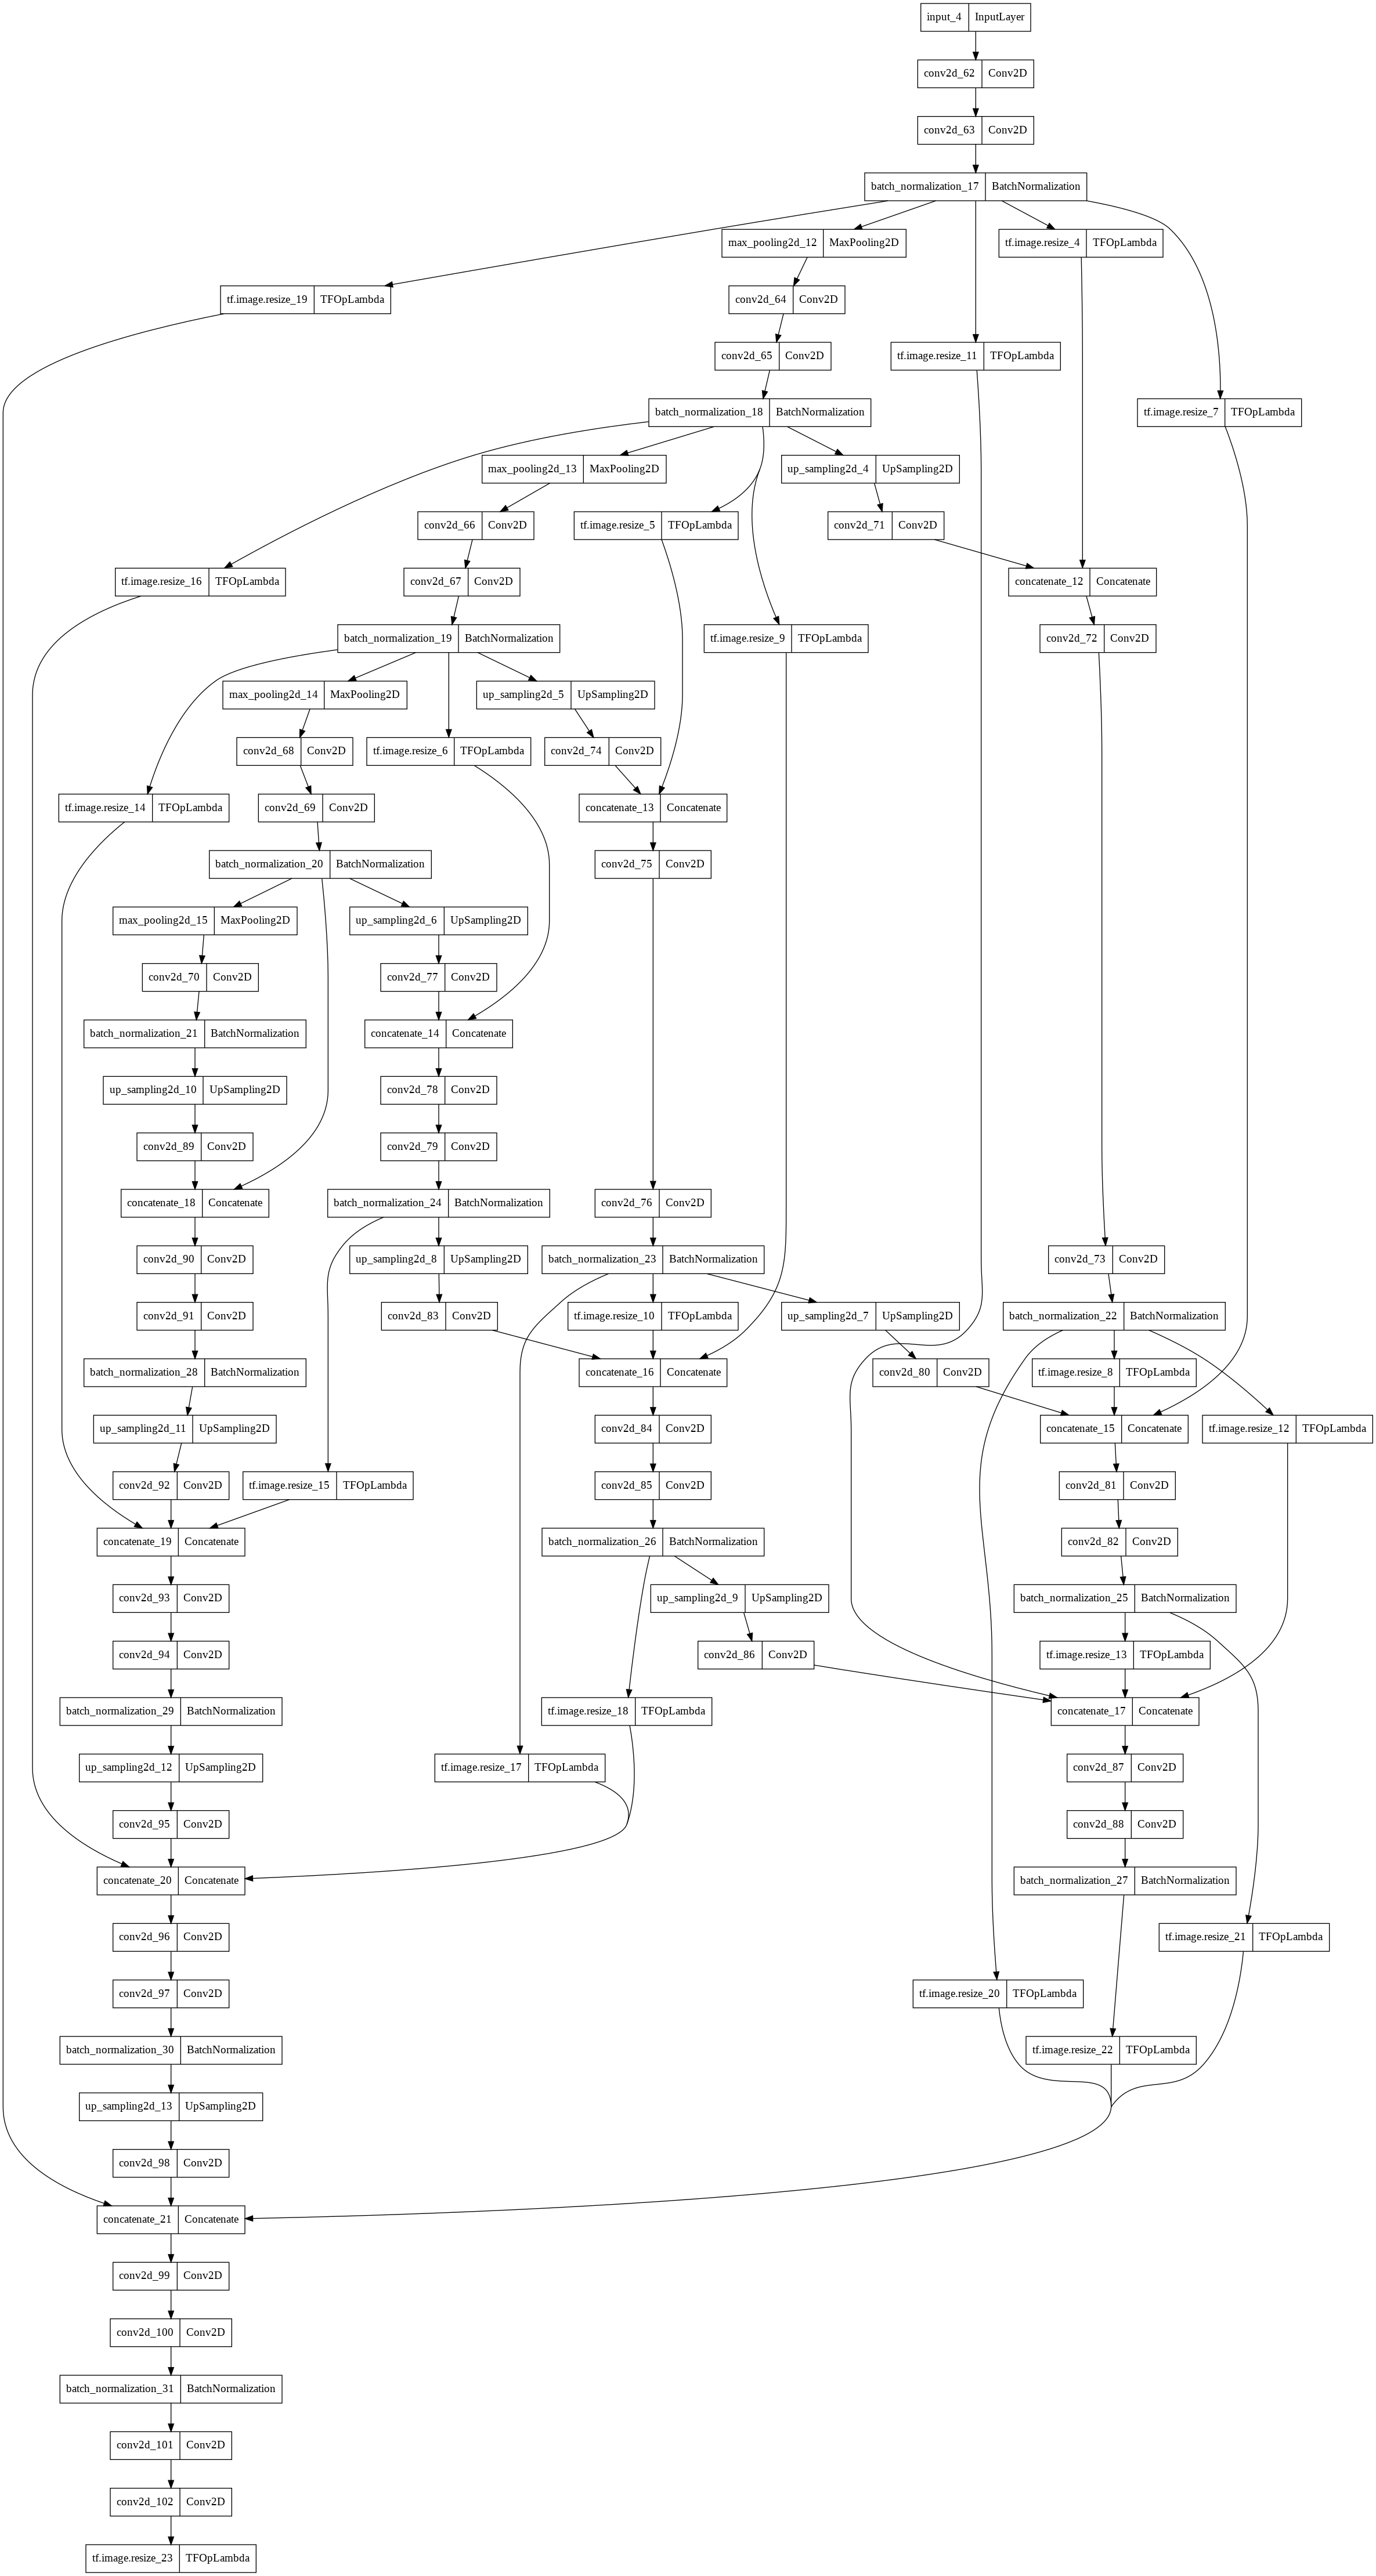

In [ ]:
tf.keras.utils.plot_model(UNet_p, to_file='/content/drive/MyDrive/data/U-Net++.png')

---

###모델 학습

In [ ]:
UNet_p.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy')

UNet_plus = UNet_p.fit_generator(
    generator=train_generator,
    validation_data=test_generator,
    steps_per_epoch=len(train_generator),
    epochs=100,
)

Epoch 1/100
43/43 [==============================] - 18s 301ms/step - loss: 0.7226 - val_loss: 0.6850
Epoch 2/100
43/43 [==============================] - 10s 225ms/step - loss: 0.6549 - val_loss: 0.6865
Epoch 3/100
43/43 [==============================] - 10s 226ms/step - loss: 0.6124 - val_loss: 0.6486
Epoch 4/100
43/43 [==============================] - 10s 225ms/step - loss: 0.5682 - val_loss: 0.7378
Epoch 5/100
43/43 [==============================] - 10s 225ms/step - loss: 0.5288 - val_loss: 0.5750
Epoch 6/100
43/43 [==============================] - 10s 225ms/step - loss: 0.4774 - val_loss: 0.5438
Epoch 7/100
43/43 [==============================] - 10s 225ms/step - loss: 0.4354 - val_loss: 0.4651
Epoch 8/100
43/43 [==============================] - 10s 225ms/step - loss: 0.3884 - val_loss: 0.4558
Epoch 9/100
43/43 [==============================] - 10s 225ms/step - loss: 0.3607 - val_loss: 0.4016
Epoch 10/100
43/43 [==============================] - 10s 225ms/step - loss: 0.330

---

###모델 결과 저장 및 시각화

방금 학습한 모델 결과를 저장해주고 시각화 해서 확인해봅니다.

In [ ]:
model_path6 = '/content/drive/MyDrive/data/model6.h5'
UNet_p.save(model_path6)

In [ ]:
def draw_unet_history(history, model_name='hist1'):
    plt.figure(figsize=(12,4))
    plt.plot(history.history['loss'], 'r')
    plt.plot(history.history['val_loss'], 'b')
    plt.title(f'{model_name} Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['loss', 'val_loss'], loc='upper left')

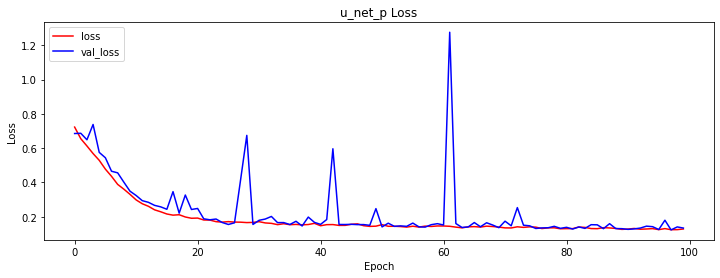

In [ ]:
draw_unet_history(UNet_plus, 'u_net_p')

---

###U-Net++제작(자체 제작)

이번에는 U-Net++모델을 한번 직접 만들어보도록 하겠습니다.

In [ ]:
def conv_batch(layer, filters):
    conv = Conv2D(filters, 3, activation='relu', padding='valid',kernel_initializer='he_normal')(layer)
    conv = Conv2D(filters, 3, activation='relu', padding='valid',kernel_initializer='he_normal')(conv)
    batch = BatchNormalization()(conv)
    
    return batch

def build_UNet_plus1(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)
    
    conv1 = conv_batch(inputs, 64)
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = conv_batch(pool1, 128)
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = conv_batch(pool2, 256)
    
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = conv_batch(pool3, 512)
    
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
    batch5 = BatchNormalization()(conv5)
    
    
    up_conv2 = Conv2DTranspose(64, 2, activation='relu', padding='same', strides=(2,2), kernel_initializer='he_normal')(conv2)
    skip_crop_conv1 = tf.image.resize(conv1, (up_conv2.shape[1], up_conv2.shape[2]))
    merge1_1 = concatenate([skip_crop_conv1, up_conv2])
    conv1_1 = conv_batch(merge1_1, 64)
    
    up_conv3 = Conv2DTranspose(128, 2, activation='relu', padding='same', strides=(2,2), kernel_initializer='he_normal')(conv3)
    skip_crop_conv2 = tf.image.resize(conv2, (up_conv3.shape[1], up_conv3.shape[2]))
    merge2_1 = concatenate([skip_crop_conv2 , up_conv3])
    conv2_1 = conv_batch(merge2_1, 128)
    
    up_conv4 = Conv2DTranspose(256, 2, activation='relu', padding='same', strides=(2,2), kernel_initializer='he_normal')(conv4)
    skip_crop_conv3 = tf.image.resize(conv3, (up_conv4.shape[1], up_conv4.shape[2]))
    merge3_1 = concatenate([skip_crop_conv3, up_conv4])
    conv3_1 = conv_batch(merge3_1, 256)
    
    up_conv2_1 = Conv2DTranspose(64, 2, activation='relu', padding='same', strides=(2,2), kernel_initializer='he_normal')(conv2_1)
    skip_crop_conv1 = tf.image.resize(conv1, (up_conv2_1.shape[1], up_conv2_1.shape[2]))
    skip_crop_conv1_1 = tf.image.resize(conv1_1, (up_conv2_1.shape[1], up_conv2_1.shape[2]))
    merge1_2 = concatenate([skip_crop_conv1, skip_crop_conv1_1, up_conv2_1])
    conv1_2 = conv_batch(merge1_2, 64)
    
    up_conv3_1 = Conv2DTranspose(256, 2, activation='relu', padding='same', strides=(2,2), kernel_initializer='he_normal')(conv3_1)

    skip_crop_conv2 = tf.image.resize(conv2, (up_conv3_1.shape[1], up_conv3_1.shape[2]))
    skip_crop_conv2_1 = tf.image.resize(conv2_1, (up_conv3_1.shape[1], up_conv3_1.shape[2]))
    merge2_2 = concatenate([skip_crop_conv2, skip_crop_conv2_1, up_conv3_1])
    conv2_2 = conv_batch(merge2_2, 256)

    up_conv2_2 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(conv2_2)
    skip_crop_conv1 = tf.image.resize(conv1, (up_conv2_2.shape[1], up_conv2_2.shape[2]))
    skip_crop_conv1_1 = tf.image.resize(conv1_1, (up_conv2_2.shape[1], up_conv2_2.shape[2]))
    skip_crop_conv1_2 = tf.image.resize(conv1_2, (up_conv2_2.shape[1], up_conv2_2.shape[2]))
    merge1_3 = concatenate([skip_crop_conv1, skip_crop_conv1_1, skip_crop_conv1_2, up_conv2_2])
    conv1_3 = conv_batch(merge1_3, 64)
    
    
    up1 = Conv2DTranspose(512, 2, activation='relu', padding='same', strides=(2,2), kernel_initializer='he_normal')(batch5)
    merge1 = concatenate([conv4,up1])
    conv6 = conv_batch(merge1, 512)

    up2 = Conv2DTranspose(256, 2, activation='relu', padding='same', strides=(2,2), kernel_initializer='he_normal')(conv6)
    crop_conv3 = tf.image.resize(conv3, (up2.shape[1], up2.shape[2]))
    crop_conv3_1 = tf.image.resize(conv3_1, (up2.shape[1], up2.shape[2]))
    merge2 = concatenate([crop_conv3, crop_conv3_1, up2])
    conv7 = conv_batch(merge2, 256)

    up3 = Conv2DTranspose(128, 2, activation='relu', padding='same', strides=(2,2), kernel_initializer='he_normal')(conv7)
    crop_conv2 = tf.image.resize(conv2, (up3.shape[1], up3.shape[2]))
    crop_conv2_1 = tf.image.resize(conv2_1, (up3.shape[1], up3.shape[2]))
    crop_conv2_2 = tf.image.resize(conv2_2, (up3.shape[1], up3.shape[2]))
    merge3 = concatenate([crop_conv2, crop_conv2_1, crop_conv2_2, up3])
    conv8 = conv_batch(merge3, 128)

    up4 = Conv2DTranspose(64, 2, activation='relu', padding='same', strides=(2,2), kernel_initializer='he_normal')(conv8)
    crop_conv1 = tf.image.resize(conv1, (up4.shape[1], up4.shape[2]))
    crop_conv1_1 = tf.image.resize(conv1_1, (up4.shape[1], up4.shape[2]))
    crop_conv1_2 = tf.image.resize(conv1_2, (up4.shape[1], up4.shape[2]))
    crop_conv1_3 = tf.image.resize(conv1_3, (up4.shape[1], up4.shape[2]))
    merge4 = concatenate([crop_conv1, crop_conv1_1, crop_conv1_2, crop_conv1_3, up4])
    conv9 = conv_batch(merge4, 64)
    conv9 = Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)     
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)
    conv10 = tf.image.resize(conv10, (input_shape[0], input_shape[1]))

    model = Model(inputs = inputs, outputs = conv10)
    
    return model

In [ ]:
UNet_p1 = build_UNet_plus1()
UNet_p1.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_103 (Conv2D)            (None, 222, 222, 64  1792        ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_104 (Conv2D)            (None, 220, 220, 64  36928       ['conv2d_103[0][0]']             
                                )                                                           

---

###모델 학습

In [ ]:
UNet_p1.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy')

UNet_plus1 = UNet_p1.fit_generator(
    generator=train_generator,
    validation_data=test_generator,
    steps_per_epoch=len(train_generator),
    epochs=100,
)

Epoch 1/100
43/43 [==============================] - 12s 184ms/step - loss: 0.2271 - val_loss: 0.4626
Epoch 2/100
43/43 [==============================] - 7s 167ms/step - loss: 0.1827 - val_loss: 0.6900
Epoch 3/100
43/43 [==============================] - 7s 167ms/step - loss: 0.1785 - val_loss: 0.6892
Epoch 4/100
43/43 [==============================] - 7s 166ms/step - loss: 0.1766 - val_loss: 0.6877
Epoch 5/100
43/43 [==============================] - 7s 166ms/step - loss: 0.1755 - val_loss: 0.4723
Epoch 6/100
43/43 [==============================] - 7s 167ms/step - loss: 0.1743 - val_loss: 0.2743
Epoch 7/100
43/43 [==============================] - 7s 167ms/step - loss: 0.1732 - val_loss: 0.2064
Epoch 8/100
43/43 [==============================] - 7s 167ms/step - loss: 0.1717 - val_loss: 0.1952
Epoch 9/100
43/43 [==============================] - 7s 168ms/step - loss: 0.1693 - val_loss: 0.6789
Epoch 10/100
43/43 [==============================] - 7s 168ms/step - loss: 0.1690 - val_l

---

###모델 결과 저장

In [ ]:
model_path7 = '/content/drive/MyDrive/data/model7.h5'
UNet_p1.save(model_path7)

---

##모델 IOU 값 확인
세그멘테이션이 성능을 정량적으로 측정하기 위한 방법으로 IoU(Intersection over Union)를 계산하게 됩니다. 

IoU를 계산하는 방법은 지난 시간에 소개한 바 있으므로 

해당 내용을 활용하여 구현해 보겠습니다.

IoU를 계산하려면 모델이 도로 영역이라고 

판단한 부분이 1로, 나머지 부분이 0으로 표시된 행렬, 그리고 라벨 데이터에서 

도로 영역이 1, 나머지 부분이 0으로 표시된 행렬이 필요합니다. 

각각을 prediction, target이라고 불렀을 때 

이를 계산하는 함수를 구현해 보겠습니다. 

위에 구현했던 get_output을 좀 더 확장해서 

output, prediction, target을 함께 리턴하도록 구현해 봅시다.

In [ ]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return

In [ ]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    
    plt.figure(figsize=(12, 20))
    plt.imshow(output)

    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

---

###U-Net모델(노드 실습 코드) 결과 확인

IoU : 0.777363


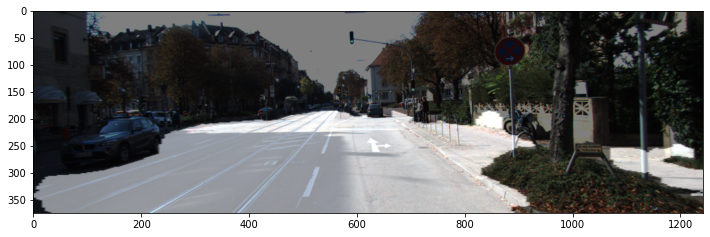

In [ ]:
i = 1
output, prediction, target = get_output(
     hist1, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

---

###U-Net모델(자체 제작) 결과 확인

IoU : 0.798042


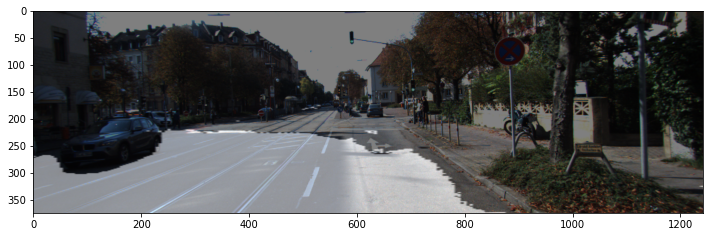

In [ ]:
i = 1
output, prediction, target = get_output(
     unet3, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

---

###U-Net모델(UpSampling2D) 결과 확인

IoU : 0.793140


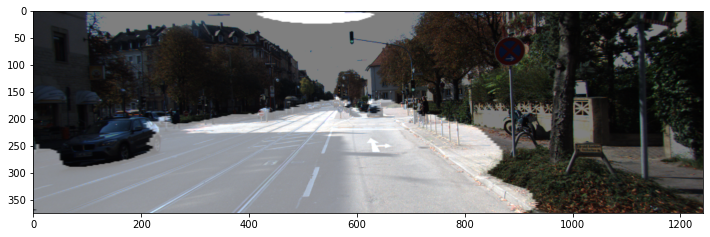

In [ ]:
i = 1
output, prediction, target = get_output(
     unet4, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

---

###U-Net++모델(깃허브 참고) 결과 확인

IoU : 0.850343


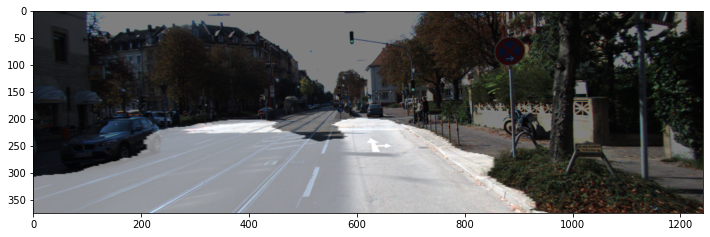

In [ ]:
i = 1
output, prediction, target = get_output(
     UNet_p, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

---

###U-Net++모델(자체 제작) 결과 확인

IoU : 0.573940


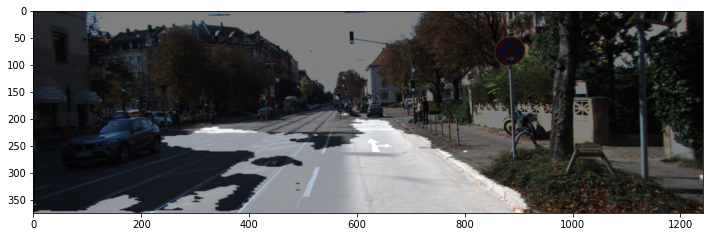

In [ ]:
i = 1
output, prediction, target = get_output(
     UNet_p1, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

----

##마무리

총 IOU값 결과는 다음과 같다.

U-Net

|U-Net(노드)|U-Net(자체)|U-Net(up)|
|---|---|---|
|0.77|0.79|0.79|

U-Net++

|U-Net++(깃허브)|U-Net++(자체)|
|---|---|
|0.85|0.57|


###어려웠던 점

- 참고하지 않으면 모델을 만들기 어려웠다.

- U-Net++를 직접 구현해보았지만 잘못된 것인지 성능이 나오지 않았다.

- 직접 구현을 하지 못했다.

- 실습 노드에서는 batch normalization 사용하지 않았지만 논문에서는 사용함

###결론

U-Net과 U-Net++를 구현하여 두 모델에 IOU를 비교해보았습니다.

**U-Net에서는 BatchNormalization을 사용한게 가장 높은 성능을 보여주었고**

**두 모델 중 성능은 U-Net++가 가장 뛰어난 성능을 보여주었습니다**.

왜 그렇게 나왔을까요?

가장 먼저 **U-Net성능은 노드에서는 Dropout을 사용하여 과적합을 방지**했습니다.

하지만 **논문에서는 BatchNormalization를 사용**한다고 하였죠

실제로 **BatchNormalization를 사용했을때, 성능이 더 좋습니다**.

왜 그럴까요?

**BatchNormalization을 사용이유**는 다음과 같습니다.

- 학습 속도가 개선된다 (학습률을 높게 설정할 수 있기 때문)

- 가중치 초깃값 선택의 의존성이 적어진다 (학습을 할 때마다 출력값을 정규화하기 때문)

- 과적합(overfitting) 위험을 줄일 수 있다 (Dropout 같은 기법 대체 가능)

- Gradient Vanishing 문제 해결

**Dropout으로 대체 가능하지만 논문에서는 conv을 2개 통과할때마다** **BatchNormalization을 사용**했습니다.

그렇기 때문에 **Dropout을 적게 사용한 실습 코드보다 좋은 성능**을 낼수있었던거 같습니다. 

다음으로는 U-Net이 U-Net++보다 뛰어난 성능을 낼 수 있었던 이유입니다.

**U-Net과 다른 UNet++의 특징은 skip connection이 dense convolution block으로** 이루어져 있다는 것 입니다. 

**Encoder와 Decoder 사이에는 여러 개의 dense convolution block이 존재**합니다.

**각각의 convolution layer는 같은 level에 있는** 

**다른 block들과 lower level에 있는 block을 up-sampling 한 것을 합쳐서 얻습니다**. 

그러므로 **좀 더 세그멘테이션을 세밀하게 진행**할 수 있는거 같습니다.

실제로 결과 이미지를 확인해보시면 U-Net++ 결과 사진에 경계가 더 부드러워지고

도로영역만 잘 추출해내는걸 확인하실수 있습니다.